# 1) Curve Fitting

Developing a code to fit polynomials of different order to a noisy polynomial of third order. 
The code will use a "fake" $\chi^2$ test as a proxy for the Cost function, where the test is defined as "fake" because it is ultimately not divided by the standard deviation of the sample. This is acceptable because the test is used just as a way to calculate how similar our trained model is to the original curve rather than calculating the $\chi^2$ for its precise statistical significance.

In the notebook we will then use gradient descent on the "fake" $\chi^2$ between the trained model and the original curve, in order to minimise the value of it and obtain a curve resembling the model.

First, we will import the necessary modules, and select style of the plots.

In [1]:
#importing numpy and matplotlib, and some additional style modules
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.style 
import matplotlib as mpl 


mpl.rcParams['figure.figsize'] = [4, 2.5] #selecting figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # selecting definition of plots

Here we will define some of the functions that we will use in the next cells.

I have tried to write the functions at all times in a vectorised way, or by using existing modules. The effect of not writing for loops manually is likely not visible at such low numbers of repetitions, however it should become notable at higher numbers. 

In [2]:
def polyModelWithNoise(x,theta,sigma):
    """
    Function that creates a polynomial of a given order, based on the following inputs:
    x - array of x values
    theta - vector of parameters for the polynomial such that 𝑦(𝑥)=∑𝜃_i * 𝑥_𝑖
    sigma - standard deviation of the noise distribution that will be added to the final polynomial function
    
    """
    #using the polyval function to define the polynomial, 
    #and adding noise with a standard deviation sigma and size equal to the number of x points
    y = np.polynomial.polynomial.polyval(x,theta) + np.random.normal(scale=sigma, size=len(x))
    return y
        
def polyGradient(x,theta):
    """
    Function that returns the gradient of the polynomial function with respect to the parameters theta.
    
    For a certain polynomial y(x) = 𝜃_0 + 𝜃_1 * x + 𝜃_2 * x^2 + 𝜃_3 * x^3 ...
    the derivative of the function with respect to each parameter 𝜃_i will simply equal x^i
    
    This function, at any input x and theta, outputs a vector containing [1,x,x^2,x^3....x^i] where i corresponds to
    the length of the vector theta -1 (since we start counting from 0).
    
    inputs:
    x - array of x values
    theta - vector of parameters for the polynomial such that 𝑦(𝑥)=∑𝜃_i * 𝑥_𝑖
    
    """
    #creating a 2 dimensional x-array so that in the np.power function, x and exponents are compatible in shape 
    x_2d = np.tile(x, (len(theta),1))
    
    #creating an array of exponents to be used for the powers, this has length = length of theta array,
    #and it is transposed so to be compatible with the x_2d array
    exponents = np.array([np.arange(len(theta))]).T
    
    #this vectorisation allows for better scaling up
    return np.power(x_2d, exponents)

def get_chisq(x, theta, theta_true, sigma):
    """
    Function taken from week1_CurveFitting notebook.
    It calculates the chi^2 test value between the original noisy function and
    the nth-order polynomial we are trying to fit
    
    inputs:
    x - array of x values
    theta - vector of parameters for the polynomial to train
    theta_true - vector of parameters for the true polynomial to be fitted
    sigma - standard deviation of the noise distribution that will be added to the final polynomial function
    
    """
    return np.average((polyModelWithNoise(x,theta,sigma)-polyModelWithNoise(x,theta_true,0))**2) #using chi^2 formula


### Implementing Stochastic Gradient Descent

In this first part of the notebook, we will plot a first-order polynomial with some noise theta, and then will implement stochastic gradient descent to fit a curve to it. 
Essentially what is being done is normal linear regression.

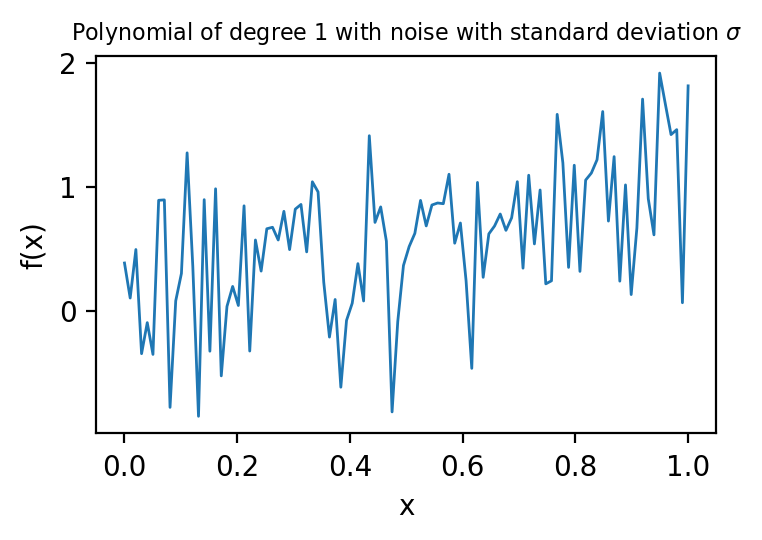

In [3]:
x_points = np.linspace(0,1,100) #creating x points for plotting
theta = [0,1] #defining vector of theta value for the curve
sigma = 0.5 #adding sigma for the noise

#creating the plot, using subplots method
fig, ax = plt.subplots() 
ax.plot(x_points,polyModelWithNoise(x_points,theta,sigma),linewidth=1)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("Polynomial of degree 1 with noise with standard deviation $\sigma$", fontsize=8);

Applying the gradient descent algorithm, which will train the parameters for 100 iterations until the trained curve resembles the original ones. 

In [4]:
numSteps=100 #Number of steps for minimisation
theta=[-1,0.5] #Start place
theta_true = [0,1] #true value of theta
eta=0.5 #'Learning' rate

#initialising all the arrays necessary for subsequent plotting of cost function against number of repetitions.
chiSqArray=np.zeros(numSteps)  #Array for plotting
thetaArray=np.zeros((numSteps+1,2))  #Array for plotting 
thetaArray[0]=theta 

sigma = 0.5 #sigma of noisy polynomial

#gradient descent algorithm, iterating for all the steps
for i in range(numSteps):
    
    x= np.random.uniform(0,1,10) #sample of 10 random x values between 0 and 1
    y_true = polyModelWithNoise(x, theta_true, 0.5) #generating corresponding y "true" values with noise
    y_current = polyModelWithNoise(x, theta, 0) #generating y values for curve with parameters yet to be fitted
    chiSq=get_chisq(x,theta, theta_true, sigma) #calculating the chi^2
    chiSqArray[i]=chiSq #saving the chi^2 for subsequent plotting
    #calculating the deviation between two polynomials
    deviation=polyModelWithNoise(x,theta, sigma)-polyModelWithNoise(x,theta_true,0) 
    #executing the update in parameters
    theta-=eta*np.average(deviation[None,:]*polyGradient(x,theta),axis=1)
    thetaArray[i+1]=theta #saving the new parameters
    

Now I will plot two graphs:

1) The cost function/chi^2 as a function of the iterations. It clearly shows the cost function reducing overall, with random oscillation because it is not a "full" gradient descent but rather it uses batches of data. This is done to speed up the process, even though it means that it does not go in the direction of perfect descent at every step.

2) The plot of the original noisy curve with the fitted curve

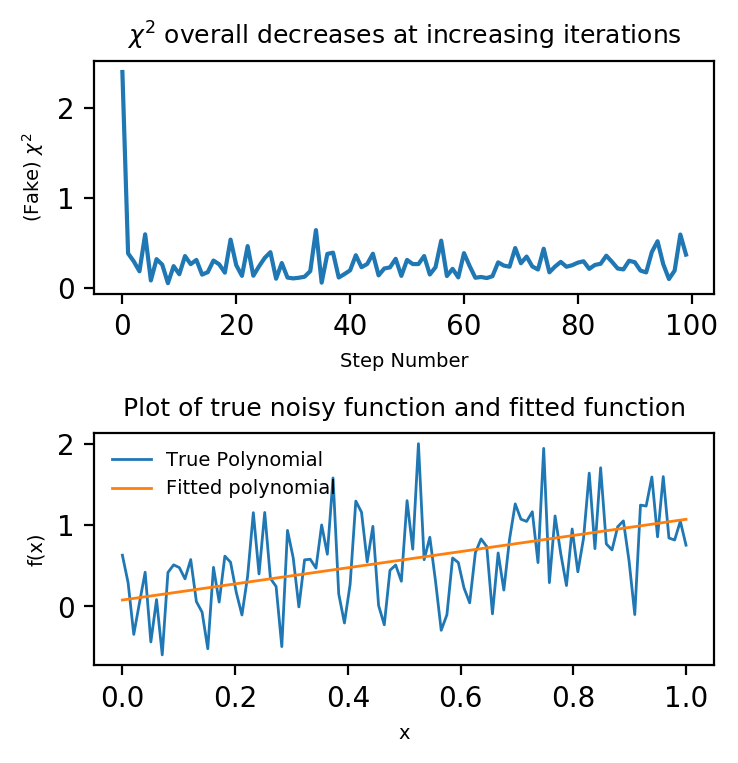

In [5]:
#plotting the two graphs using the subplots method
fig, ax = plt.subplots(2,1, figsize=(4,4))  
plt.subplots_adjust(hspace = 0.6) #setting the vertical space between subplots

count=np.arange(numSteps+1) #defining the x range

#creating the first plot
ax[0].plot(count[:-1],chiSqArray,linewidth=1.5)#plotting chi^2 vs iterations
ax[0].set_xlabel("Step Number", fontsize=7)
ax[0].set_ylabel(r"(Fake) $\chi^2$", fontsize=7)
ax[0].set_title("$\chi^2$ overall decreases at increasing iterations", fontsize=9)

#creating the second plot - fitted polynomial
ax[1].plot(x_points,polyModelWithNoise(x_points,theta,sigma),linewidth=1,label="True Polynomial")
ax[1].set_xlabel("x", fontsize=7)
ax[1].set_ylabel("f(x)", fontsize=7)

#creating the second plot - true polynomial
ax[1].plot(x_points,polyModelWithNoise(x_points,thetaArray[-1],0),linewidth=1, label="Fitted polynomial")
ax[1].legend(fontsize=7)
ax[1].set_title("Plot of true noisy function and fitted function", fontsize=9);

## Thirs order polynomial

Now I will define a third-degree noisy polynomial, and will try to fit three polynomials to it, with respectively 1,3, and 7 degrees. I will also plot the $\chi^2$ for each of these polynomials.

In [6]:
def initialise_theta(order, wMax):
    """
    Function that initialises theta as a vector of dimensions 'order+1' and random numbers between -wMax and wMax.
    """
    
    return np.random.uniform(low=-1*wMax, high=+1*wMax, size=order+1)

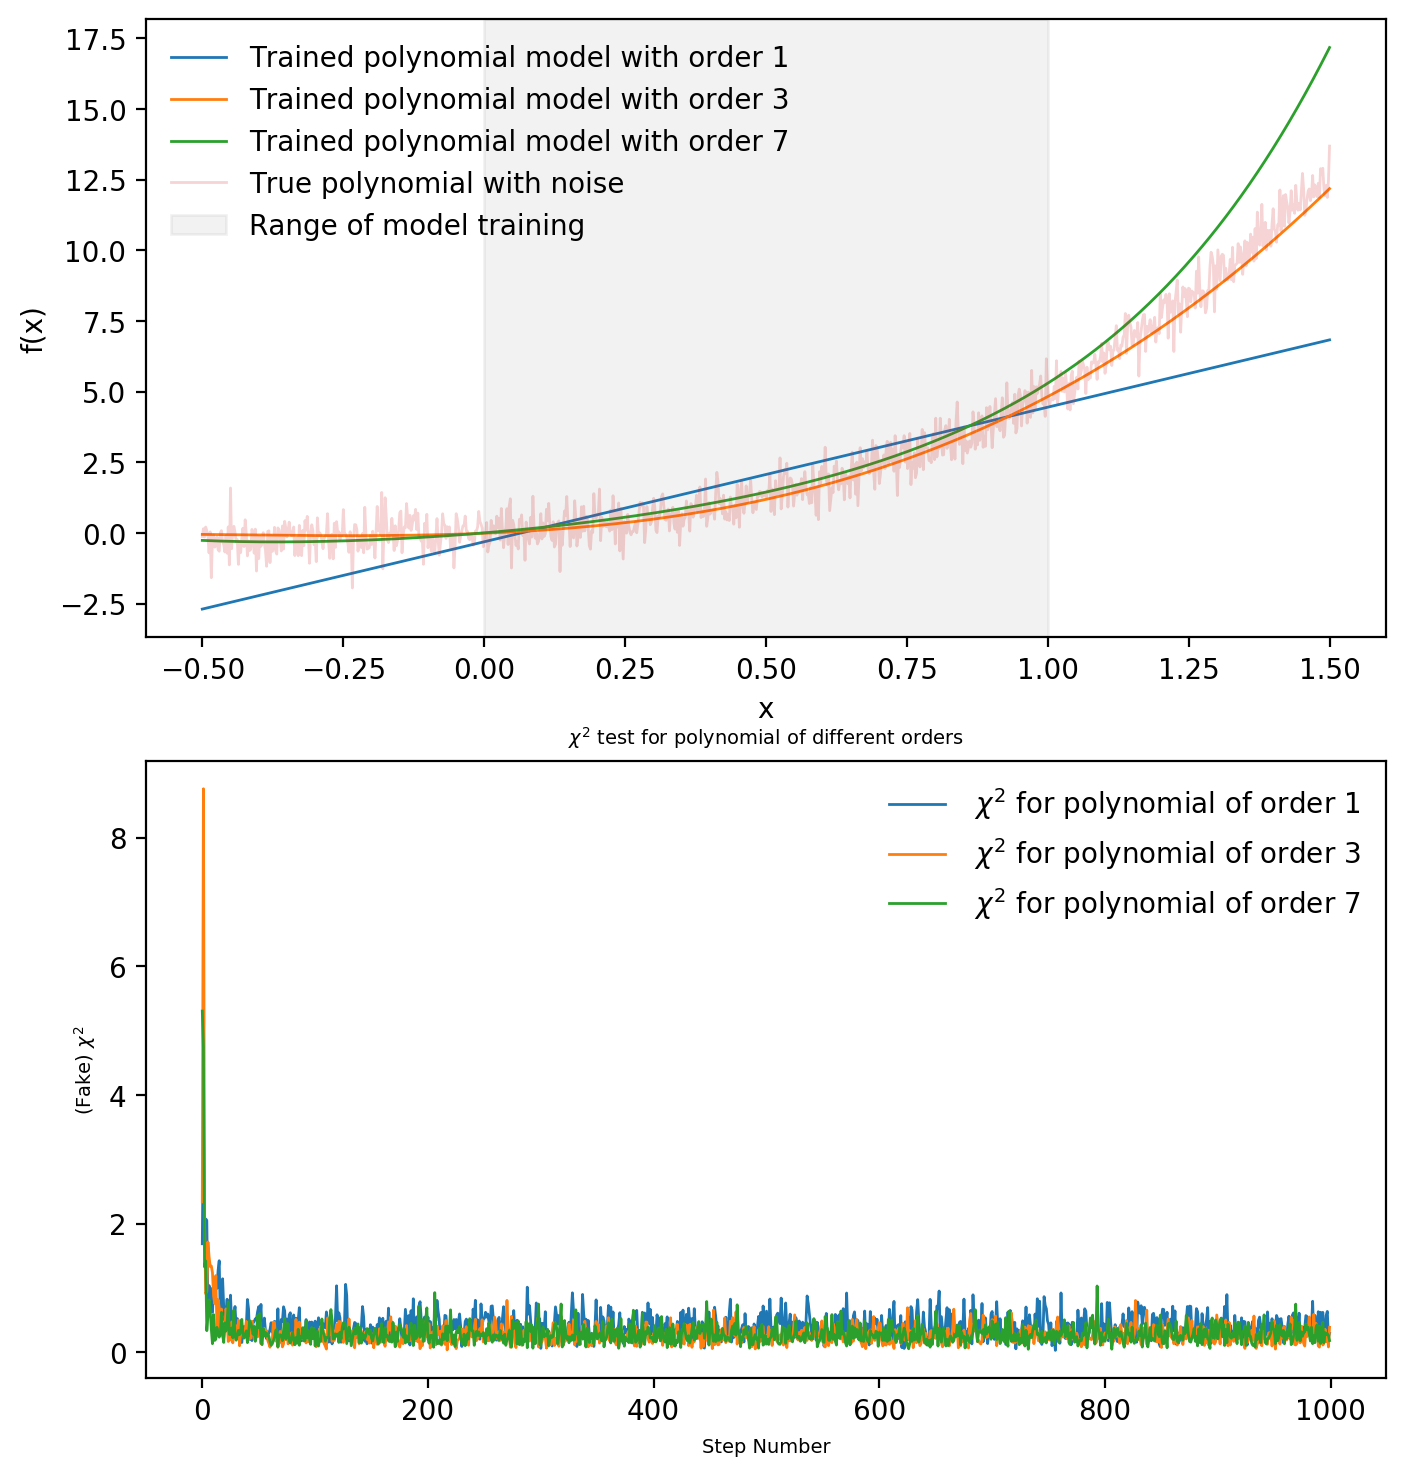

In [7]:
numSteps=1000 #Number of steps for minimisation
theta_true = [0,1,2,2] #true value of theta
eta=0.5 #'Learning' rate
sigma = 0.5 #sigma of noisy polynomial
x_points = x_points = np.linspace(-0.5,1.5,1000) # defining points in the interval -0.5, 1.5 


fig, ax = plt.subplots(2,1, figsize=(8,9)) #creating plot using subplots method
count=np.arange(numSteps+1) #defining x-axis range for chi^2 plot
wMax = 2 #setting wMax for initialisation

#iterating over 3 different polynomials to fit
for j in [1,3,7]:
    theta = initialise_theta(j, wMax) #randomly initialising theta
    chiSqArray=np.zeros(numSteps)  #Array for plotting
    thetaArray=np.zeros((numSteps+1,j+1))  #Array for plotting 
    thetaArray[0]=theta

    #iterating over steps for gradient descent algorithm
    for i in range(numSteps):
        x= np.random.uniform(0,1,10) #sample of 10 random x values between 0 and 1
        y_true = polyModelWithNoise(x, theta_true, 0.5) #generating corresponding y "true" values with noise
        y_current = polyModelWithNoise(x, theta, 0) #generating y values for curve with parameters yet to be fitted
        chiSq=get_chisq(x,theta, theta_true, sigma) #calculating the chi^2
        chiSqArray[i]=chiSq #saving the chi^2 for subsequent plotting
         #calculating the deviation between two polynomials
        deviation=polyModelWithNoise(x,theta, sigma)-polyModelWithNoise(x,theta_true,0)
        #executing the update in parameters
        theta-=eta*np.average(deviation[None,:]*polyGradient(x,theta),axis=1)
        thetaArray[i+1]=theta #saving the new parameters
   
    #creating the first plot for the trained polynomials
    ax[0].plot(x_points,polyModelWithNoise(x_points,theta,0),linewidth=1,label="Trained polynomial model with order %i"%j)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("f(x)")
    
    #creating the second plot with the chi^2 test
    ax[1].plot(count[:-1],chiSqArray,linewidth=1, label = " $\chi^2$ for polynomial of order %i"%j)
    ax[1].set_xlabel("Step Number", fontsize=7)
    ax[1].set_ylabel(r"(Fake) $\chi^2$", fontsize=7)
    ax[1].set_title('$\chi^2$ test for polynomial of different orders', fontsize=7) 
    ax[1].legend()
    
#plotting the true polynomials with the fitted ones
ax[0].plot(x_points,polyModelWithNoise(x_points,theta_true,sigma),linewidth=1, label="True polynomial with noise", alpha=0.2)
 #defining the grey region on the x-axis where the polynomial was trained
ax[0].axvspan(0, 1, color='grey', alpha=0.1, label="Range of model training")
ax[0].legend();


By looking at both the plots and (less effectively) the $\chi^2$ it is clear that the best performing polynomial is the 3rd-order one, and the worst performing one is the 1st-order one. 

This was expected, as the 1st-order polynomial has too few degrees of freedom to effectively reproduce the original curve. To use a neural network analogy - it is like trying to train a 1 hidden layer NN to distinguish between human faces. This first curve therefore does not perform well within the training area, even if it is able to reduce the $\chi^2$ effectively nonetheless, and especially it performs poorly outside of the training area. 

As for the 3rd-order polynomial, the curve is particularly accurate both within and outside of the training area. Within the training area it nearly perfectly resembles the original "true" polynomial, while outside the training area - given the fact that it does not have any more degrees of freedom than the true curve - it performs nearly equally good. 

For the 7th-order polynomial, within the training interval, the curve fits again nearly perfectly the true curve. This can also be seen in the $\chi^2$ plot. Outside of the training area on the other hand, because of its additional degrees of freedom, it performs poorly. Sometimes the curve has an inflection point for example right outside of the training interval, while sometimes it does not, but still it does not fit the data well. 
To be able to see both cases, there might be the need to re-run the cell many times, as the way the parameters are trained is overall subject to random fluctuations. 